# Goal

* Multiple Regression on Matrices (MRM) analysis on IndD dataset
  * `IndD` = one sample per individual
  * Just mammalia samples

# Var

In [1]:
work_dir = '/ebio/abt3_projects/Georg_animal_feces/data/modulating_factors/MRM/IndD/'

# phyloseq
physeq_file = '/ebio/abt3_projects/Georg_animal_feces/data/16S/LLA/phyloseq/physeq_r5k.RDS'

# beta-div distance matrices
beta_div_file = '/ebio/abt3_projects/Georg_animal_feces/data/16S/LLA/diversity/beta_div.RDS'

# host phylogeny
host_tree_dist_file = '/ebio/abt3_projects/Georg_animal_feces/data/animal/phylogeny/TT/unified_metadata_complete_20180625_rn_16S-r5k_IndD_dist.RDS'

# params
threads = 12

# Init

In [15]:
library(dplyr)
library(tidyr)
library(ggplot2)
library(stringr)
library(ape)
library(ecodist)
library(phyloseq)
library(doParallel)
source('/ebio/abt3_projects/Georg_animal_feces/code/init.R') 

In [5]:
set.seed(9384)

In [3]:
make_dir(work_dir)

Directory already exists: /ebio/abt3_projects/Georg_animal_feces/data/modulating_factors/MRM/IndD/ 


## Functions

In [6]:
dist_mtx_order = function(d, x){
    # Ordering distance matrixes
    # d = distance matrix (dist class)
    # x = vector to order dist. obj. by
    m = d %>% as.matrix
    d = as.dist(m[x,x])
    return(d)
}

# Load

## Phyloseq

In [9]:
# phyloseq obj.
physeq = readRDS(physeq_file) %>%
    subset_samples(class=='Mammalia')
physeq

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 30290 taxa and 160 samples ]
sample_data() Sample Data:       [ 160 samples by 171 sample variables ]
tax_table()   Taxonomy Table:    [ 30290 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 30290 tips and 29752 internal nodes ]

### Metadata

In [11]:
# metadata
metadata = physeq %>%
    sample_data %>%
    as.matrix %>%
    as.data.frame %>%
    mutate(X.SampleID = rownames(.))

metadata %>% dfhead

Warning message in class(X) <- NULL:
“Setting class(x) to NULL;   result will no longer be an S4 object”

[1] 160 171


X.SampleID,BarcodeSequence,LinkerPrimerSequence,Primer,ReversePrimer,Barcode_ID,sample_number,host_subject_id,host_german_name,host_common_name,⋯,wellplate_position_Illumina,Cornell_Dilution_DNA_Illumina,Num_Illumina,Num,sorting_454,comments_additional,DNA_box_20180622,sample_vol_20180622,sample_label_20180622,Description
X1.Eurasian.Beaver,ACTCACGGTATG,CATGCTGCCTCCCGTAGGAGT,GCCTCCCTCGCGCCATCAG,AGAGTTTGATCCTGGCTCAG,338R_BC0049,1,1,Biber,Eurasian.Beaver,⋯,B12,4,120,18,18,NA,1,20,1,NA
X101.Horse,ACGACGTCTTAG,CATGCTGCCTCCCGTAGGAGT,GCCTCCCTCGCGCCATCAG,AGAGTTTGATCCTGGCTCAG,338R_BC0030,101,101,Hauspferd,Horse,⋯,E8,16,344,160,160,NA,2,20,101,NA
X102.Kulan,ACGAGTGCTATC,CATGCTGCCTCCCGTAGGAGT,GCCTCCCTCGCGCCATCAG,AGAGTTTGATCCTGGCTCAG,338R_BC0031,102,102,Khulan,Kulan,⋯,E9,16,345,161,161,NA,2,20,102,NA


## Beta diversity

In [12]:
rescale_dist_mtx = function(m){
    m = m %>% as.matrix
    labs = m %>% colnames
    n_row = m %>% nrow
    n_col = m %>% ncol
    x = m %>% as.vector 
    x = scales::rescale(x) 
    m = matrix(x, nrow=n_row, ncol=n_col)
    colnames(m) = labs
    rownames(m) = labs
    m = m %>% as.dist
    return(m)
}

In [13]:
# load beta-diversity dist. matrices
beta_d = readRDS(beta_div_file)

# status
lapply(beta_d, function(x) x %>% as.vector %>% summary)

$bray_curtis
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.1104  0.9984  1.0000  0.9890  1.0000  1.0000 

$jaccard
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.3886  0.9956  1.0000  0.9912  1.0000  1.0000 

$unweighted_unifrac
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.2149  0.7783  0.8494  0.8361  0.9163  0.9881 

$weighted_unifrac
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.02332 0.46492 0.55024 0.53904 0.62490 0.94211 


In [20]:
# filtering beta-div to samples in metadata
beta_d = lapply(beta_d, dist_mtx_order, metadata$X.SampleID) 

lapply(beta_d, function(x) x %>% as.matrix %>% dim)

$bray_curtis
[1] 160 160

$jaccard
[1] 160 160

$unweighted_unifrac
[1] 160 160

$weighted_unifrac
[1] 160 160

## Host phylogeny

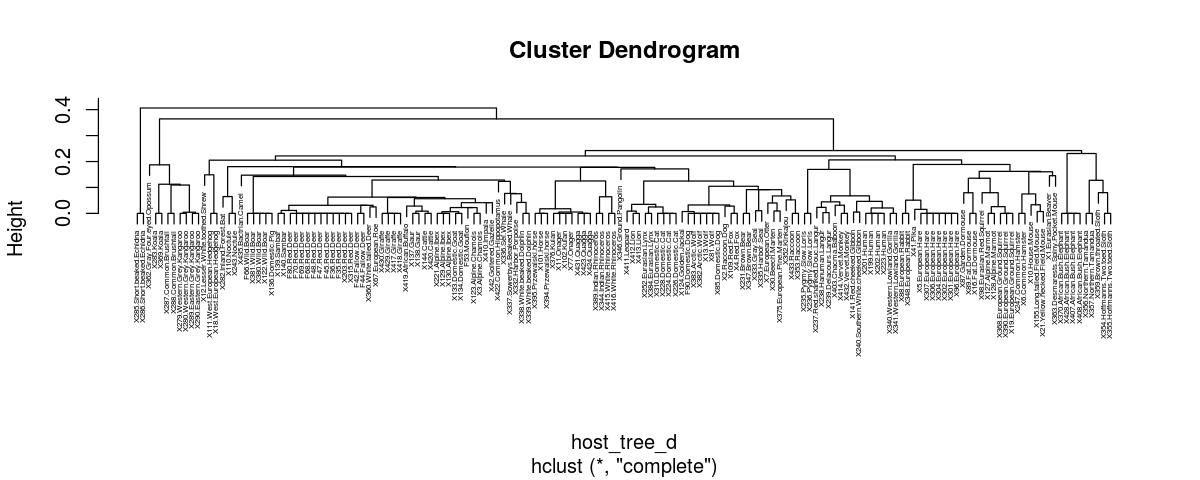

In [26]:
# patristic distance
host_tree_d = readRDS(host_tree_dist_file)

# filtering
host_tree_d = dist_mtx_order(host_tree_d, beta_d[[1]] %>% labels)

# plotting
options(repr.plot.height=4, repr.plot.width=10)
plot(hclust(host_tree_d), cex=0.4)

# Checking overlap

In [27]:
# beta-div and host tree
setdiff(beta_d[[1]] %>% labels, host_tree_d %>% labels) %>% print
setdiff(host_tree_d %>% labels, beta_d[[1]] %>% labels) %>% print

character(0)
character(0)


In [28]:
# beta-div and metaata
setdiff(beta_d[[1]] %>% labels, metadata$X.SampleID) %>% print
setdiff(metadata$X.SampleID, beta_d[[1]] %>% labels) %>% print

character(0)
character(0)


# Making distance matrices

## Diet (detailed) distance

* Detailed diet categories

In [29]:
dietD = metadata %>%
    dplyr::select(X.SampleID, diet_vertebrate, diet_invertebrate, diet_fruit,
                  diet_flowers_nectar_pollen, diet_leaves_branches_bark_buds, diet_seeds,
                  diet_grass_waterplants, diet_roots_tubers) %>%
    mutate(diet_invertebrate = gsub(' .+', '', diet_invertebrate) %>% as.factor) %>%
    as.data.frame

rownames(dietD) = dietD$X.SampleID
dietD$X.SampleID = NULL

cn = colnames(dietD)
dietD = dietD %>% 
    apply(1, function(x) ifelse(x=='yes', 1, 0)) %>%
    t %>% as.data.frame
colnames(dietD) = cn

# status
dietD %>% head

,diet_vertebrate,diet_invertebrate,diet_fruit,diet_flowers_nectar_pollen,diet_leaves_branches_bark_buds,diet_seeds,diet_grass_waterplants,diet_roots_tubers
X1.Eurasian.Beaver,0,0,0,0,1,0,1,1
X101.Horse,0,0,0,0,0,1,1,0
X102.Kulan,0,0,0,0,1,0,1,0
X109.Red.Fox,1,1,1,0,0,0,0,0
X110.Noctule,0,1,0,0,0,0,0,0
X111.West.European.Hedgehog,1,1,0,0,0,0,0,0


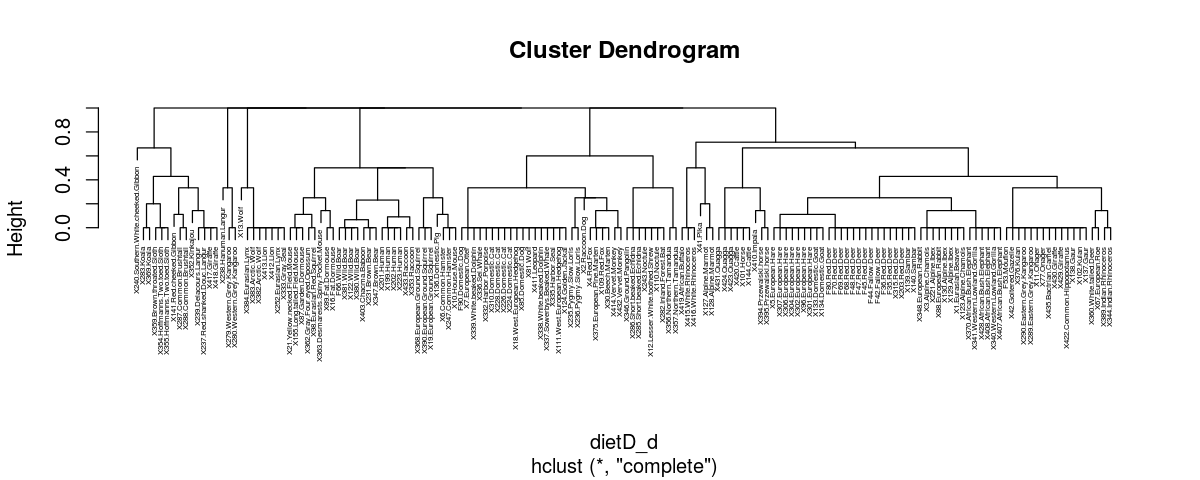

In [30]:
dietD_d = vegan::vegdist(dietD, metric='jaccard')

options(repr.plot.height=4)
plot(hclust(dietD_d), cex=0.4)

## Digestive tract distance

In [31]:
dtD = metadata %>%
    distinct(X.SampleID, .keep_all=TRUE) %>%
    dplyr::select(X.SampleID, 
                  digestive_system, digestive_system_detail, 
                  ruminant, pseudoruminants) %>%
    mutate(digestive_system = gsub('_', ' ', digestive_system),
           digestive_system_detail = gsub('^_', '', digestive_system_detail),
           digestive_system_detail = gsub('_', ' ', digestive_system_detail),
           digestive_system_detail = gsub(' +', ' ', digestive_system_detail)) %>%
    mutate(digestive_system = digestive_system %>% as.factor,
           digestive_system_detail = digestive_system_detail %>% as.factor) %>%
    as.data.frame

rownames(dtD) = dtD$X.SampleID
dtD$X.SampleID = NULL

dtD %>% head

,digestive_system,digestive_system_detail,ruminant,pseudoruminants
X1.Eurasian.Beaver,hindgut,hindgut,no,no
X101.Horse,hindgut,hindgut,no,no
X102.Kulan,hindgut,hindgut,no,no
X109.Red.Fox,simple,simple,no,no
X110.Noctule,NA,NA,no,no
X111.West.European.Hedgehog,simple,simple,no,no


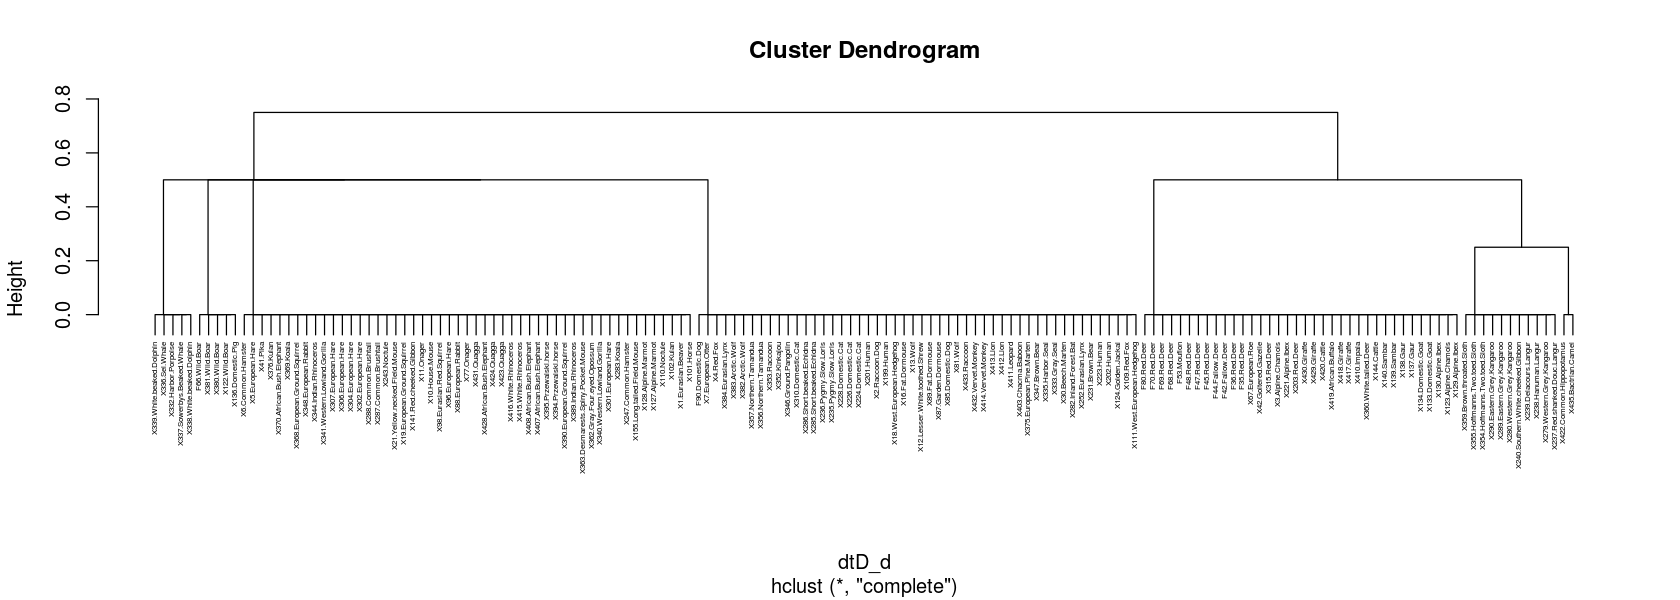

In [32]:
dtD_d = cluster::daisy(dtD, metric='gower')

options(repr.plot.height=5, repr.plot.width=14)
plot(hclust(dtD_d), cex=0.4)

## Habitat distance

* Gower distance on `habitat_detail`

In [33]:
metadata$habitat_detail %>% table %>% print
metadata$habitat_detail_1 %>% table %>% print
metadata$habitat_detail_2 %>% table %>% print

.
anthropogenic habitat    cultivated habitat             grassland 
                    8                    10                    28 
 saline water habitat   terrestrial habitat              woodland 
                    7                    64                    43 
.
anthropogenic habitat    cultivated habitat                forest 
                    8                    10                    43 
            grassland        marine habitat                meadow 
                    1                     7                    14 
              pasture                steppe   terrestrial habitat 
                    4                     9                    64 
.
anthropogenic habitat    cultivated habitat          flood meadow 
                    8                    10                    14 
               forest             grassland        marine habitat 
                   43                     1                     7 
              pasture                steppe   terrestria

In [35]:
habitatD = metadata %>%
    dplyr::select(X.SampleID, habitat_detail, habitat_detail_1, habitat_detail_2) %>%
    as.data.frame

rownames(habitatD) = habitatD$X.SampleID
habitatD$X.SampleID = NULL

habitatD %>% dfhead

[1] 160   3


,habitat_detail,habitat_detail_1,habitat_detail_2
X1.Eurasian.Beaver,terrestrial habitat,terrestrial habitat,terrestrial habitat
X101.Horse,grassland,pasture,pasture
X102.Kulan,grassland,steppe,steppe


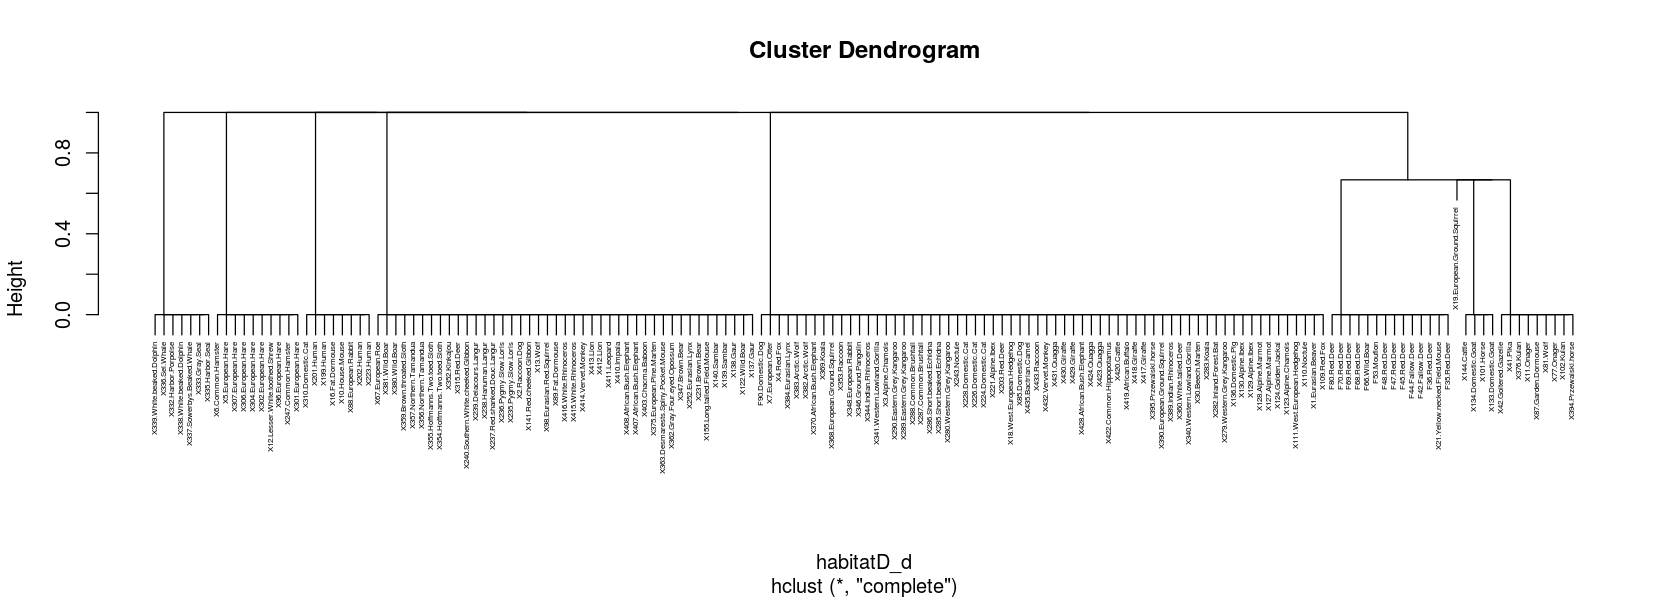

In [36]:
habitatD_d = cluster::daisy(habitatD, metric='gower') 

options(repr.plot.height=5, repr.plot.width=14)
plot(hclust(habitatD_d), cex=0.4)

## Geographic distance

In [37]:
geo = metadata %>% 
    dplyr::select(X.SampleID, latitude, longitude) %>%
    mutate(latitude = latitude %>% as.Num,
           longitude = longitude %>% as.Num) %>%
    as.data.frame

rownames(geo) = geo$X.SampleID

geo$latitude %>% summary %>% print
geo$longitude %>% summary %>% print
geo %>% dfhead    

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -35.83   11.42   47.50   30.08   48.21   55.29 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -84.10   15.33   16.37   27.95   31.59  140.12 
[1] 160   3


,X.SampleID,latitude,longitude
X1.Eurasian.Beaver,X1.Eurasian.Beaver,48.47611,16.58389
X101.Horse,X101.Horse,48.78333,15.06667
X102.Kulan,X102.Kulan,43.70759,98.34961


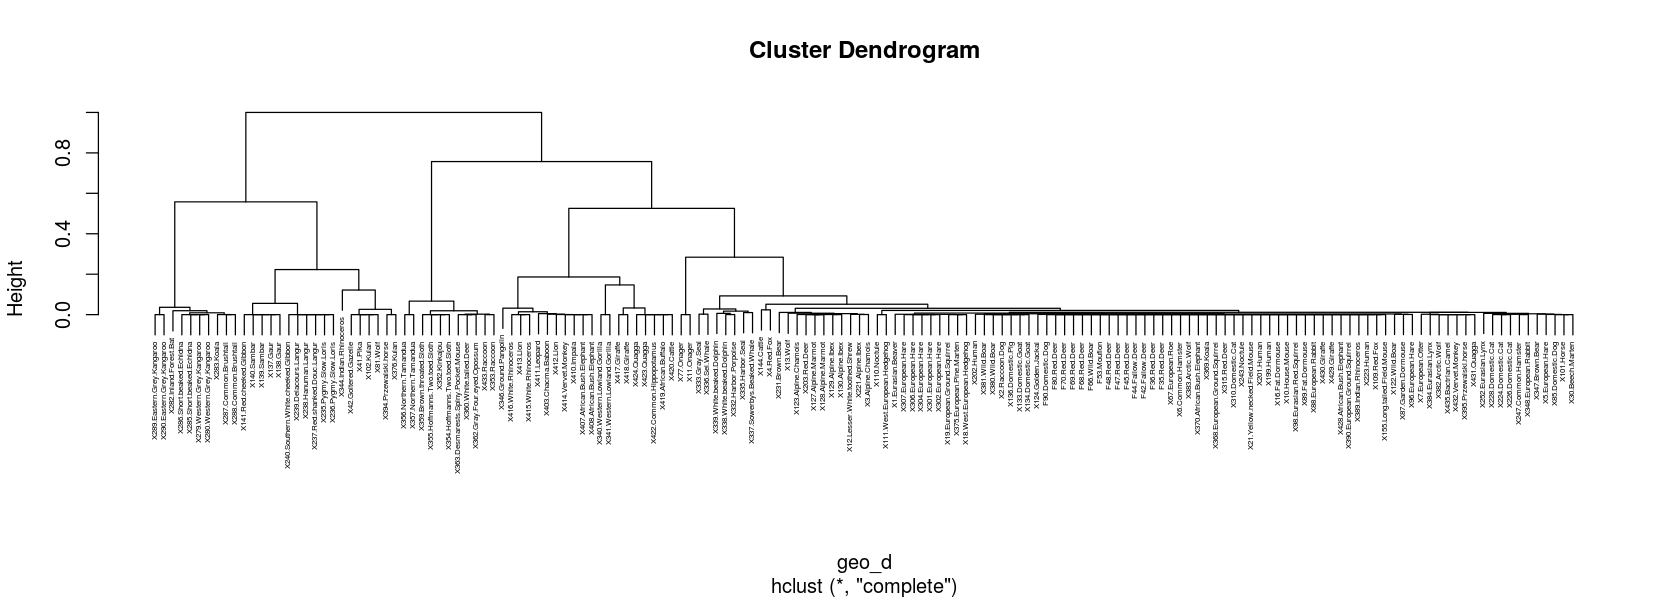

In [39]:
.pairwise_distGeo = function(x, y){
    d = geosphere::distGeo(x[c('longitude', 'latitude')],
                           y[,c('longitude', 'latitude')])
    return(d)
}

pairwise_distGeo = function(df){
    x = df[,c('longitude', 'latitude')]
    geo_d = apply(x, 1, .pairwise_distGeo, y=x)
    rescale_dist_mtx(as.dist(geo_d))
}

geo_d = pairwise_distGeo(geo)

options(repr.plot.height=5, repr.plot.width=14)
plot(hclust(geo_d), cex=0.4)

## Sampling details distance

* Gower distance of sampling methodology
  * assessing variance explained by technical factors

In [40]:
x = metadata$sampling_method %>% unique %>% as.vector
samp = metadata %>% 
    dplyr::select(X.SampleID, sampling_method, captive_wild, wild_domesticated) 

rownames(samp) = samp$X.SampleID
samp$X.SampleID = NULL

samp %>% dfhead

[1] 160   3


,sampling_method,captive_wild,wild_domesticated
X1.Eurasian.Beaver,feces sampling,wild,wild
X101.Horse,feces sampling,captive,domesticated
X102.Kulan,feces sampling,wild,wild


In [41]:
# summary
samp %>% summary

             sampling_method  captive_wild    wild_domesticated
 dried feces sampling:  7    captive: 34   domesticated: 16    
 feces sampling      :138    human  :  4   wild        :144    
 gut section         :  9    wild   :122                       
 swab                :  6                                      

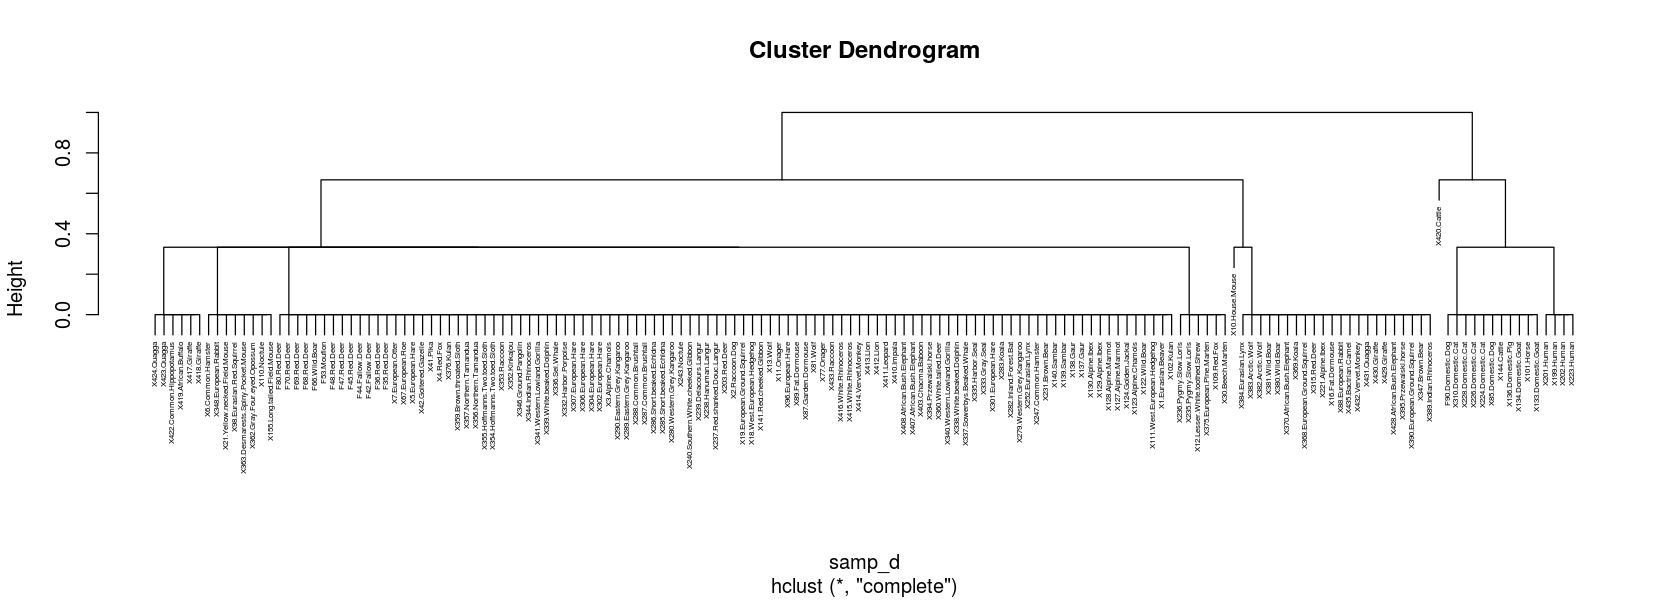

In [42]:
# distance matrix
samp_d = cluster::daisy(samp, metric='gower') 

options(repr.plot.height=5, repr.plot.width=14)
plot(hclust(samp_d), cex=0.4)

# Ordering matrices

In [43]:
# beta-div labels
beta_d %>% labels

[1] "bray_curtis"        "jaccard"            "unweighted_unifrac"
[4] "weighted_unifrac"

In [44]:
# ordering by beta-div metrix
X = labels(beta_d$weighted_unifrac)
host_tree_d_o = dist_mtx_order(host_tree_d, X)
dietD_d_o = dist_mtx_order(dietD_d, X)
habitatD_d_o = dist_mtx_order(habitatD_d, X)
geo_d_o = dist_mtx_order(geo_d, X)
samp_d_o = dist_mtx_order(samp_d, X)
dtD_d_o = dist_mtx_order(dtD_d, X)

In [45]:
# check
X %>% length %>% print
dtD_d_o %>% labels %>% length %>% print

[1] 160
[1] 160


# MRM intra-spec sensitivity

* MRM permuted for samples within each species

In [46]:
# number of permutated SpecD datasetst
nperm_datasets = 100
# number of permutations per MRM analysis
nperm = 1000

## Functions

In [47]:
#' randomly selecting one per group
#' L : list of distance matrixes used for MRM
#' df_grps : data.frame (sample, group)
one_per_group = function(L, df_grps, ...){
    # get subsample
    colnames(df_grps) = c('Sample', 'Group')
    df_grps = df_grps %>%
        group_by(Group) %>%
        sample_n(1)
    # subsetting all matrices
    lapply(L, function(x) dist_mtx_order(x, df_grps$Sample))
}

In [48]:
#' MRM on one subsample rep
#' i : rep number
#' L : list of list of distance matrices generated by `one_per_group()`
# nperm : nperm function for MRM
# f : MRM fomulat
mrm_each = function(i, L, f, nperm=99){
    m = L[[i]]
    f = as.formula(f)
    x = ecodist::MRM(f, nperm=nperm, mrank=TRUE)
    # coefficients
    df = x$coef %>% as.data.frame
    colnames(df) = c('coef', 'coef_pval')
    df$variable = rownames(df)
    df$R2 = x$r.squared[1]
    df$pval = x$r.squared[2]
    df$F = x$F.test[1]
    df$rep = i
    return(df)
}

In [105]:
# renaming output
rename_df = data.frame(old_name = c('m$diet', 'm$digest', 'm$geo', 'm$habitat', 'm$host_phy', 'm$samp'),
                       new_name = c('Diet', 'Digestive\nsystem', 'Geography', 'Habitat', 'Phylogeny', 'Sample\ntype'))

## One per species

In [100]:
# grouping samples by species
df_grps = metadata %>% 
    filter(X.SampleID %in% labels(dietD_d_o)) %>%
    dplyr::select(X.SampleID, scientific_name)
df_grps %>% dfhead

[1] 160   2


X.SampleID,scientific_name
X1.Eurasian.Beaver,Castor_fiber
X101.Horse,Equus_caballus
X102.Kulan,Equus_hemionus


### Weighted unifrac

In [101]:
# creating subsample permutations of the distance matrices
L = list(beta = beta_d$weighted_unifrac,
         host_phy = host_tree_d_o,
         diet = dietD_d_o,
         digest = dtD_d_o, 
         habitat = habitatD_d_o,
         geo = geo_d_o,
         samp = samp_d_o)

m_perm = lapply(as.list(1:nperm_datasets), function(x) one_per_group(L, df_grps, x))
m_perm %>% length 

[1] 100

#### Model 1

In [102]:
# MRM on each permutation (in parallel)
doParallel::registerDoParallel(threads)
x = as.list(1:length(m_perm))
f = 'm$beta ~ m$host_phy + m$diet + m$digest + m$habitat + m$geo + m$samp'
mrm_res = plyr::llply(x, mrm_each, L=m_perm, f=f, nperm=nperm, .parallel=TRUE)
mrm_res = do.call(rbind, mrm_res)
mrm_res %>% dfhead

[1] 700   7


,coef,coef_pval,variable,R2,pval,F,rep
Int,1178.8954286,0.994,Int,0.07998475,0.001,48.01903,1
m$host_phy,0.1295312,0.028,m$host_phy,0.07998475,0.001,48.01903,1
m$diet,0.2692347,0.001,m$diet,0.07998475,0.001,48.01903,1


In [103]:
# summary of overall model
mrm_res %>%
    distinct(R2, pval, rep) %>%
    summary

       R2               pval              rep        
 Min.   :0.04864   Min.   :0.00100   Min.   :  1.00  
 1st Qu.:0.07283   1st Qu.:0.00100   1st Qu.: 25.75  
 Median :0.07990   Median :0.00100   Median : 50.50  
 Mean   :0.08062   Mean   :0.00141   Mean   : 50.50  
 3rd Qu.:0.08854   3rd Qu.:0.00100   3rd Qu.: 75.25  
 Max.   :0.10709   Max.   :0.00800   Max.   :100.00  

Warning message:
“Column `variable`/`old_name` joining character vector and factor, coercing into character vector”

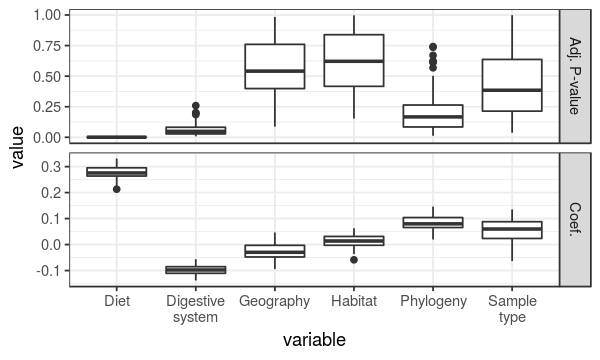

In [106]:
# formatting results
mrm_res_s = mrm_res %>% 
    filter(variable != 'Int') %>%
    gather(category, value, -variable, -R2, -pval, -F, -rep) %>%
    mutate(category = ifelse(category == 'coef', 'Coef.', 'Adj. P-value'))

mrm_res_s = mrm_res_s %>%
    inner_join(rename_df, c('variable'='old_name')) %>%
    dplyr::select(-variable) %>%
    rename('variable' = new_name)           

p = ggplot(mrm_res_s, aes(variable, value)) +
    geom_boxplot() +
    facet_grid(category ~ ., scales='free_y') +
    theme_bw()

options(repr.plot.width=5, repr.plot.height=3)
plot(p)

In [107]:
# significance
mrm_res %>% 
    group_by(variable) %>%
    summarize(pval_sensitivity = 1 - sum(coef_pval < 0.05) / length(pval)) %>%
    ungroup() %>%
    mutate(sig_pval_sensitivity = pval_sensitivity < 0.05)

variable,pval_sensitivity,sig_pval_sensitivity
Int,1.00,FALSE
m$diet,0.00,TRUE
m$digest,0.49,FALSE
m$geo,1.00,FALSE
m$habitat,1.00,FALSE
m$host_phy,0.84,FALSE
m$samp,0.98,FALSE


#### Model 2

In [108]:
# MRM on each permutation (in parallel)
doParallel::registerDoParallel(threads)
x = as.list(1:length(m_perm))
f = 'm$beta ~ m$host_phy + m$diet + m$habitat + m$geo + m$samp'
mrm_res = plyr::llply(x, mrm_each, L=m_perm, f=f, nperm=nperm, .parallel=TRUE)
mrm_res = do.call(rbind, mrm_res)
mrm_res %>% dfhead

[1] 600   7


,coef,coef_pval,variable,R2,pval,F,rep
Int,1056.6826565,1.000,Int,0.0701312,0.001,50.00381,1
m$host_phy,0.1203505,0.032,m$host_phy,0.0701312,0.001,50.00381,1
m$diet,0.2380535,0.001,m$diet,0.0701312,0.001,50.00381,1


In [109]:
# summary of overall model
mrm_res %>%
    distinct(R2, pval, rep) %>%
    summary

       R2               pval              rep        
 Min.   :0.04540   Min.   :0.00100   Min.   :  1.00  
 1st Qu.:0.06549   1st Qu.:0.00100   1st Qu.: 25.75  
 Median :0.07181   Median :0.00100   Median : 50.50  
 Mean   :0.07260   Mean   :0.00163   Mean   : 50.50  
 3rd Qu.:0.08024   3rd Qu.:0.00200   3rd Qu.: 75.25  
 Max.   :0.09987   Max.   :0.00900   Max.   :100.00  

Warning message:
“Column `variable`/`old_name` joining character vector and factor, coercing into character vector”

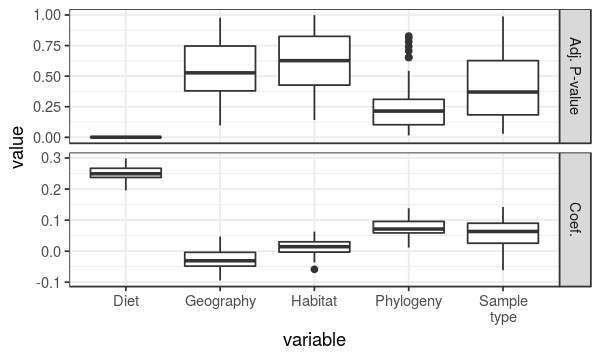

In [110]:
# fomatting output
mrm_res_s = mrm_res %>% 
    filter(variable != 'Int') %>%
    gather(category, value, -variable, -R2, -pval, -F, -rep) %>%
    mutate(category = ifelse(category == 'coef', 'Coef.', 'Adj. P-value'))

mrm_res_s = mrm_res_s %>%
    inner_join(rename_df, c('variable'='old_name')) %>%
    dplyr::select(-variable) %>%
    rename('variable' = new_name)              

p = ggplot(mrm_res_s, aes(variable, value)) +
    geom_boxplot() +
    facet_grid(category ~ ., scales='free_y') +
    theme_bw() 

options(repr.plot.width=5, repr.plot.height=3)
plot(p)

In [111]:
# significance
mrm_res %>% 
    group_by(variable) %>%
    summarize(pval_sensitivity = 1 - sum(coef_pval < 0.05) / length(pval)) %>%
    ungroup() %>%
    mutate(sig_pval_sensitivity = pval_sensitivity < 0.05)

variable,pval_sensitivity,sig_pval_sensitivity
Int,1.00,FALSE
m$diet,0.00,TRUE
m$geo,1.00,FALSE
m$habitat,1.00,FALSE
m$host_phy,0.93,FALSE
m$samp,0.97,FALSE


### unweighted-unifrac

In [112]:
# creating multiple distance matrices
m = list(beta = beta_d$unweighted_unifrac,
         host_phy = host_tree_d_o,
         diet = dietD_d_o,
         digest = dtD_d_o, 
         habitat = habitatD_d_o,
         geo = geo_d_o,
         samp = samp_d_o)

m_perm = lapply(as.list(1:nperm_datasets), function(x) one_per_group(m, df_grps, x))
m_perm %>% length           

[1] 100

#### Model 1

In [113]:
# MRM on each permutation (in parallel)
doParallel::registerDoParallel(threads)
x = as.list(1:length(m_perm))
f = 'm$beta ~ m$host_phy + m$diet + m$digest + m$habitat + m$geo + m$samp'
mrm_res = plyr::llply(x, mrm_each, L=m_perm, f=f, nperm=nperm, .parallel=TRUE)
mrm_res = do.call(rbind, mrm_res)
mrm_res %>% dfhead

[1] 700   7


,coef,coef_pval,variable,R2,pval,F,rep
Int,753.09063625,1.000,Int,0.1566657,0.001,102.6066,1
m$host_phy,0.05550937,0.216,m$host_phy,0.1566657,0.001,102.6066,1
m$diet,0.36978978,0.001,m$diet,0.1566657,0.001,102.6066,1


In [114]:
# summary of overall model
mrm_res %>%
    distinct(R2, pval, rep) %>%
    summary

       R2              pval            rep        
 Min.   :0.1288   Min.   :0.001   Min.   :  1.00  
 1st Qu.:0.1515   1st Qu.:0.001   1st Qu.: 25.75  
 Median :0.1601   Median :0.001   Median : 50.50  
 Mean   :0.1603   Mean   :0.001   Mean   : 50.50  
 3rd Qu.:0.1710   3rd Qu.:0.001   3rd Qu.: 75.25  
 Max.   :0.1910   Max.   :0.001   Max.   :100.00  

Warning message:
“Column `variable`/`old_name` joining character vector and factor, coercing into character vector”

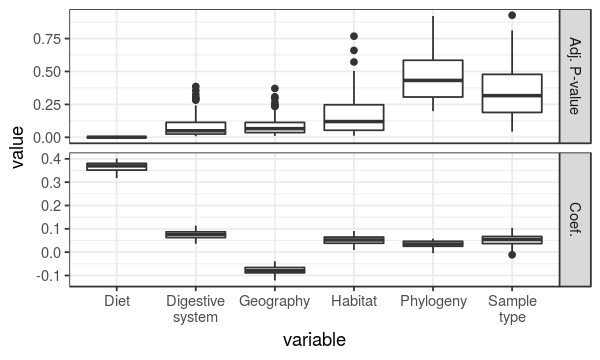

In [115]:
# formatting results
mrm_res_s = mrm_res %>% 
    filter(variable != 'Int') %>%
    gather(category, value, -variable, -R2, -pval, -F, -rep) %>%
    mutate(category = ifelse(category == 'coef', 'Coef.', 'Adj. P-value'))

mrm_res_s = mrm_res_s %>%
    inner_join(rename_df, c('variable'='old_name')) %>%
    dplyr::select(-variable) %>%
    rename('variable' = new_name)              

p = ggplot(mrm_res_s, aes(variable, value)) +
    geom_boxplot() +
    facet_grid(category ~ ., scales='free_y') +
    theme_bw()

options(repr.plot.width=5, repr.plot.height=3)
plot(p)

In [116]:
# significance
mrm_res %>% 
    group_by(variable) %>%
    summarize(pval_sensitivity = 1 - sum(coef_pval < 0.05) / length(pval)) %>%
    ungroup() %>%
    mutate(sig_pval_sensitivity = pval_sensitivity < 0.05)

variable,pval_sensitivity,sig_pval_sensitivity
Int,1.00,FALSE
m$diet,0.00,TRUE
m$digest,0.50,FALSE
m$geo,0.60,FALSE
m$habitat,0.79,FALSE
m$host_phy,1.00,FALSE
m$samp,0.98,FALSE


#### Model 2

In [117]:
# MRM on each permutation (in parallel)
doParallel::registerDoParallel(threads)
x = as.list(1:length(m_perm))
f = 'm$beta ~ m$host_phy + m$diet + m$habitat + m$geo + m$samp'
mrm_res = plyr::llply(x, mrm_each, L=m_perm, f=f, nperm=nperm, .parallel=TRUE)
mrm_res = do.call(rbind, mrm_res)
mrm_res %>% dfhead

[1] 600   7


,coef,coef_pval,variable,R2,pval,F,rep
Int,816.8997365,1.000,Int,0.1542492,0.001,120.9189,1
m$host_phy,0.0601022,0.193,m$host_phy,0.1542492,0.001,120.9189,1
m$diet,0.3853682,0.001,m$diet,0.1542492,0.001,120.9189,1


In [118]:
# summary of overall model
mrm_res %>%
    distinct(R2, pval, rep) %>%
    summary

       R2              pval            rep        
 Min.   :0.1229   Min.   :0.001   Min.   :  1.00  
 1st Qu.:0.1465   1st Qu.:0.001   1st Qu.: 25.75  
 Median :0.1555   Median :0.001   Median : 50.50  
 Mean   :0.1556   Mean   :0.001   Mean   : 50.50  
 3rd Qu.:0.1663   3rd Qu.:0.001   3rd Qu.: 75.25  
 Max.   :0.1845   Max.   :0.001   Max.   :100.00  

Warning message:
“Column `variable`/`old_name` joining character vector and factor, coercing into character vector”

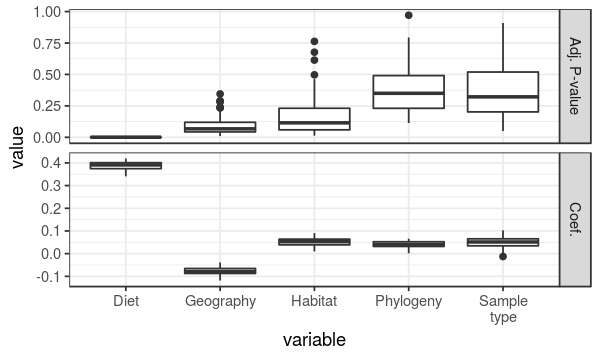

In [119]:
# formatting output
mrm_res_s = mrm_res %>% 
    filter(variable != 'Int') %>%
    gather(category, value, -variable, -R2, -pval, -F, -rep) %>%
    mutate(category = ifelse(category == 'coef', 'Coef.', 'Adj. P-value'))

mrm_res_s = mrm_res_s %>%
    inner_join(rename_df, c('variable'='old_name')) %>%
    dplyr::select(-variable) %>%
    rename('variable' = new_name)              

p = ggplot(mrm_res_s, aes(variable, value)) +
    geom_boxplot() +
    facet_grid(category ~ ., scales='free_y') +
    theme_bw() 

options(repr.plot.width=5, repr.plot.height=3)
plot(p)

In [120]:
# significance
mrm_res %>% 
    group_by(variable) %>%
    summarize(pval_sensitivity = 1 - sum(coef_pval < 0.05) / length(pval)) %>%
    ungroup() %>%
    mutate(sig_pval_sensitivity = pval_sensitivity < 0.05)

variable,pval_sensitivity,sig_pval_sensitivity
Int,1.00,FALSE
m$diet,0.00,TRUE
m$geo,0.70,FALSE
m$habitat,0.77,FALSE
m$host_phy,1.00,FALSE
m$samp,1.00,FALSE


### Bray-Curtis

In [121]:
# creating multiple distance matrices
L = list(beta = beta_d$bray_curtis,
         host_phy = host_tree_d_o,
         diet = dietD_d_o,
         digest = dtD_d_o, 
         habitat = habitatD_d_o,
         geo = geo_d_o,
         samp = samp_d_o)
m_perm = lapply(as.list(1:nperm_datasets), function(x) one_per_group(L, df_grps, x))
m_perm %>% length           

[1] 100

#### Model 1

In [122]:
# MRM on each permutation (in parallel)
doParallel::registerDoParallel(threads)
x = as.list(1:length(m_perm))
f = 'm$beta ~ m$host_phy + m$diet + m$digest + m$habitat + m$geo + m$samp'
mrm_res = plyr::llply(x, mrm_each, L=m_perm, f=f, nperm=nperm, .parallel=TRUE)
mrm_res = do.call(rbind, mrm_res)
mrm_res %>% dfhead

[1] 700   7


,coef,coef_pval,variable,R2,pval,F,rep
Int,1.369410e+03,0.999,Int,0.02355555,0.001,13.32438,1
m$host_phy,5.281194e-02,0.022,m$host_phy,0.02355555,0.001,13.32438,1
m$diet,1.261963e-01,0.001,m$diet,0.02355555,0.001,13.32438,1


In [123]:
# summary of overall model
mrm_res %>%
    distinct(R2, pval, rep) %>%
    summary

       R2               pval              rep        
 Min.   :0.01425   Min.   :0.00100   Min.   :  1.00  
 1st Qu.:0.02468   1st Qu.:0.00100   1st Qu.: 25.75  
 Median :0.02847   Median :0.00100   Median : 50.50  
 Mean   :0.02906   Mean   :0.00115   Mean   : 50.50  
 3rd Qu.:0.03231   3rd Qu.:0.00100   3rd Qu.: 75.25  
 Max.   :0.05524   Max.   :0.00800   Max.   :100.00  

Warning message:
“Column `variable`/`old_name` joining character vector and factor, coercing into character vector”

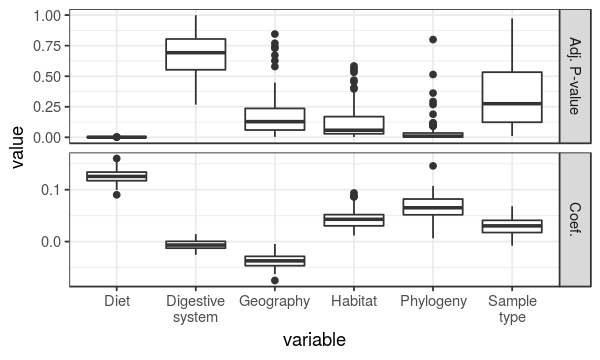

In [124]:
# formatting output
mrm_res_s = mrm_res %>% 
    filter(variable != 'Int') %>%
    gather(category, value, -variable, -R2, -pval, -F, -rep) %>%
    mutate(category = ifelse(category == 'coef', 'Coef.', 'Adj. P-value'))

mrm_res_s = mrm_res_s %>%
    inner_join(rename_df, c('variable'='old_name')) %>%
    dplyr::select(-variable) %>%
    rename('variable' = new_name)             

p = ggplot(mrm_res_s, aes(variable, value)) +
    geom_boxplot() +
    facet_grid(category ~ ., scales='free_y') +
    theme_bw()

options(repr.plot.width=5, repr.plot.height=3)
plot(p)

In [125]:
# significance
mrm_res %>% 
    group_by(variable) %>%
    summarize(pval_sensitivity = 1 - sum(coef_pval < 0.05) / length(pval)) %>%
    ungroup() %>%
    mutate(sig_pval_sensitivity = pval_sensitivity < 0.05)

variable,pval_sensitivity,sig_pval_sensitivity
Int,1.00,FALSE
m$diet,0.00,TRUE
m$digest,1.00,FALSE
m$geo,0.80,FALSE
m$habitat,0.56,FALSE
m$host_phy,0.21,FALSE
m$samp,0.89,FALSE


#### Model 2

In [126]:
# MRM on each permutation (in parallel)
doParallel::registerDoParallel(threads)
x = as.list(1:length(m_perm))
f = 'm$beta ~ m$host_phy + m$diet + m$habitat + m$geo + m$samp'
mrm_res = plyr::llply(x, mrm_each, L=m_perm, f=f, nperm=nperm, .parallel=TRUE)
mrm_res = do.call(rbind, mrm_res)
mrm_res %>% dfhead

[1] 600   7


,coef,coef_pval,variable,R2,pval,F,rep
Int,1.362548e+03,0.998,Int,0.02351496,0.001,15.96586,1
m$host_phy,5.228611e-02,0.020,m$host_phy,0.02351496,0.001,15.96586,1
m$diet,1.244117e-01,0.001,m$diet,0.02351496,0.001,15.96586,1


In [127]:
# summary of overall model
mrm_res %>%
    distinct(R2, pval, rep) %>%
    summary

       R2               pval              rep        
 Min.   :0.01425   Min.   :0.00100   Min.   :  1.00  
 1st Qu.:0.02454   1st Qu.:0.00100   1st Qu.: 25.75  
 Median :0.02843   Median :0.00100   Median : 50.50  
 Mean   :0.02893   Mean   :0.00107   Mean   : 50.50  
 3rd Qu.:0.03225   3rd Qu.:0.00100   3rd Qu.: 75.25  
 Max.   :0.05524   Max.   :0.00400   Max.   :100.00  

Warning message:
“Column `variable`/`old_name` joining character vector and factor, coercing into character vector”

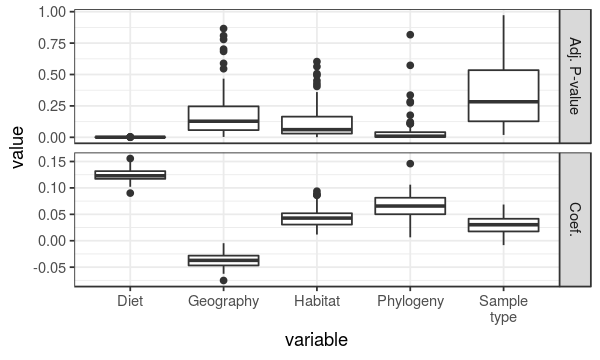

In [128]:
# formatting output
mrm_res_s = mrm_res %>% 
    filter(variable != 'Int') %>%
    gather(category, value, -variable, -R2, -pval, -F, -rep) %>%
    mutate(category = ifelse(category == 'coef', 'Coef.', 'Adj. P-value'))

mrm_res_s = mrm_res_s %>%
    inner_join(rename_df, c('variable'='old_name')) %>%
    dplyr::select(-variable) %>%
    rename('variable' = new_name)              

p = ggplot(mrm_res_s, aes(variable, value)) +
    geom_boxplot() +
    facet_grid(category ~ ., scales='free_y') +
    theme_bw() 

options(repr.plot.width=5, repr.plot.height=3)
plot(p)

In [129]:
# significance
mrm_res %>% 
    group_by(variable) %>%
    summarize(pval_sensitivity = 1 - sum(coef_pval < 0.05) / length(pval)) %>%
    ungroup() %>%
    mutate(sig_pval_sensitivity = pval_sensitivity < 0.05)

variable,pval_sensitivity,sig_pval_sensitivity
Int,1.00,FALSE
m$diet,0.00,TRUE
m$geo,0.76,FALSE
m$habitat,0.57,FALSE
m$host_phy,0.24,FALSE
m$samp,0.89,FALSE


### Jaccard

In [130]:
# creating multiple distance matrices
L = list(beta = beta_d$jaccard,
         host_phy = host_tree_d_o,
         diet = dietD_d_o,
         digest = dtD_d_o, 
         habitat = habitatD_d_o,
         geo = geo_d_o,
         samp = samp_d_o)
m_perm = lapply(as.list(1:nperm_datasets), function(x) one_per_group(L, df_grps, x))
m_perm %>% length           

[1] 100

#### Model 1

In [131]:
# MRM on each permutation (in parallel)
doParallel::registerDoParallel(threads)
x = as.list(1:length(m_perm))
f = 'm$beta ~ m$host_phy + m$diet + m$digest + m$habitat + m$geo + m$samp'
mrm_res = plyr::llply(x, mrm_each, L=m_perm, f=f, nperm=nperm, .parallel=TRUE)
mrm_res = do.call(rbind, mrm_res)
mrm_res %>% dfhead

[1] 700   7


,coef,coef_pval,variable,R2,pval,F,rep
Int,1.192104e+03,1.000,Int,0.03903788,0.001,22.43785,1
m$host_phy,7.129323e-02,0.004,m$host_phy,0.03903788,0.001,22.43785,1
m$diet,1.291503e-01,0.001,m$diet,0.03903788,0.001,22.43785,1


In [132]:
# summary of overall model
mrm_res %>%
    distinct(R2, pval, rep) %>%
    summary

       R2               pval              rep        
 Min.   :0.02188   Min.   :0.00100   Min.   :  1.00  
 1st Qu.:0.02722   1st Qu.:0.00100   1st Qu.: 25.75  
 Median :0.03081   Median :0.00100   Median : 50.50  
 Mean   :0.03193   Mean   :0.00103   Mean   : 50.50  
 3rd Qu.:0.03519   3rd Qu.:0.00100   3rd Qu.: 75.25  
 Max.   :0.04903   Max.   :0.00200   Max.   :100.00  

Warning message:
“Column `variable`/`old_name` joining character vector and factor, coercing into character vector”

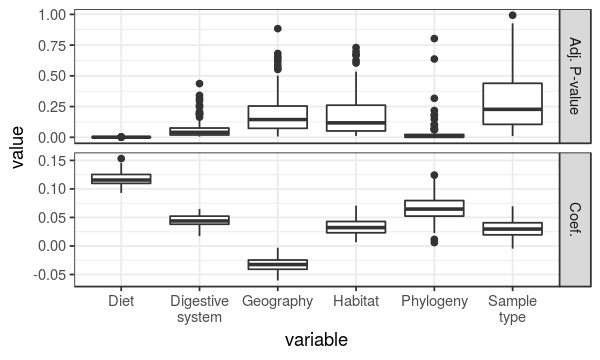

In [133]:
# formatting output
mrm_res_s = mrm_res %>% 
    filter(variable != 'Int') %>%
    gather(category, value, -variable, -R2, -pval, -F, -rep) %>%
    mutate(category = ifelse(category == 'coef', 'Coef.', 'Adj. P-value'))

mrm_res_s = mrm_res_s %>%
    inner_join(rename_df, c('variable'='old_name')) %>%
    dplyr::select(-variable) %>%
    rename('variable' = new_name)              

p = ggplot(mrm_res_s, aes(variable, value)) +
    geom_boxplot() +
    facet_grid(category ~ ., scales='free_y') +
    theme_bw()

options(repr.plot.width=5, repr.plot.height=3)
plot(p)

In [134]:
# significance
mrm_res %>% 
    group_by(variable) %>%
    summarize(pval_sensitivity = 1 - sum(coef_pval < 0.05) / length(pval)) %>%
    ungroup() %>%
    mutate(sig_pval_sensitivity = pval_sensitivity < 0.05)

variable,pval_sensitivity,sig_pval_sensitivity
Int,1.00,FALSE
m$diet,0.00,TRUE
m$digest,0.46,FALSE
m$geo,0.84,FALSE
m$habitat,0.75,FALSE
m$host_phy,0.14,FALSE
m$samp,0.87,FALSE


#### Model 2

In [135]:
# MRM on each permutation (in parallel)
doParallel::registerDoParallel(threads)
x = as.list(1:length(m_perm))
f = 'm$beta ~ m$host_phy + m$diet + m$habitat + m$geo + m$samp'
mrm_res = plyr::llply(x, mrm_each, L=m_perm, f=f, nperm=nperm, .parallel=TRUE)
mrm_res = do.call(rbind, mrm_res)
mrm_res %>% dfhead

[1] 600   7


,coef,coef_pval,variable,R2,pval,F,rep
Int,1240.9519644,1.000,Int,0.03671828,0.001,25.27217,1
m$host_phy,0.0748896,0.006,m$host_phy,0.03671828,0.001,25.27217,1
m$diet,0.1432390,0.001,m$diet,0.03671828,0.001,25.27217,1


In [136]:
# summary of overall model
mrm_res %>%
    distinct(R2, pval, rep) %>%
    summary

       R2               pval              rep        
 Min.   :0.01932   Min.   :0.00100   Min.   :  1.00  
 1st Qu.:0.02520   1st Qu.:0.00100   1st Qu.: 25.75  
 Median :0.02853   Median :0.00100   Median : 50.50  
 Mean   :0.02986   Mean   :0.00103   Mean   : 50.50  
 3rd Qu.:0.03279   3rd Qu.:0.00100   3rd Qu.: 75.25  
 Max.   :0.04655   Max.   :0.00200   Max.   :100.00  

Warning message:
“Column `variable`/`old_name` joining character vector and factor, coercing into character vector”

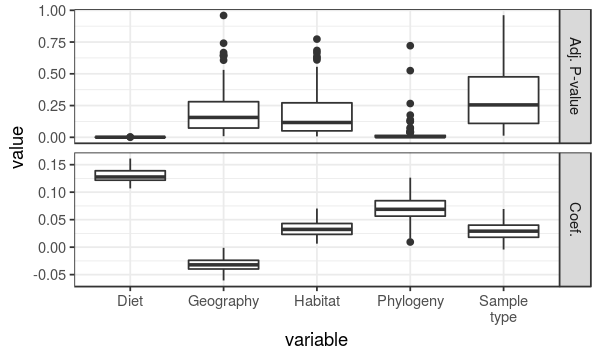

In [137]:
# formatting output
mrm_res_s = mrm_res %>% 
    filter(variable != 'Int') %>%
    gather(category, value, -variable, -R2, -pval, -F, -rep) %>%
    mutate(category = ifelse(category == 'coef', 'Coef.', 'Adj. P-value'))

mrm_res_s = mrm_res_s %>%
    inner_join(rename_df, c('variable'='old_name')) %>%
    dplyr::select(-variable) %>%
    rename('variable' = new_name)             

p = ggplot(mrm_res_s, aes(variable, value)) +
    geom_boxplot() +
    facet_grid(category ~ ., scales='free_y') +
    theme_bw() 

options(repr.plot.width=5, repr.plot.height=3)
plot(p)

In [138]:
# significance
mrm_res %>% 
    group_by(variable) %>%
    summarize(pval_sensitivity = 1 - sum(coef_pval < 0.05) / length(pval)) %>%
    ungroup() %>%
    mutate(sig_pval_sensitivity = pval_sensitivity < 0.05)

variable,pval_sensitivity,sig_pval_sensitivity
Int,1.00,FALSE
m$diet,0.00,TRUE
m$geo,0.87,FALSE
m$habitat,0.76,FALSE
m$host_phy,0.09,FALSE
m$samp,0.88,FALSE


## One per genus

In [139]:
# grouping samples by species
df_grps = metadata %>% 
    filter(X.SampleID %in% labels(dietD_d_o)) %>%
    dplyr::select(X.SampleID, genus)
df_grps %>% dfhead

[1] 160   2


X.SampleID,genus
X1.Eurasian.Beaver,Castor
X101.Horse,Equus
X102.Kulan,Equus


### Weighted Unifrac

In [140]:
# creating multiple distance matrices
L = list(beta = beta_d$weighted_unifrac,
         host_phy = host_tree_d_o,
         diet = dietD_d_o,
         digest = dtD_d_o, 
         habitat = habitatD_d_o,
         geo = geo_d_o,
         samp = samp_d_o)

m_perm = lapply(as.list(1:nperm_datasets), function(x) one_per_group(L, df_grps, x))
m_perm %>% length           

[1] 100

In [141]:
# check on sample size
m_perm[[1]][[1]] %>% as.matrix %>% dim

[1] 69 69

#### Model 1

In [142]:
# MRM on each permutation (in parallel)
doParallel::registerDoParallel(threads)
x = as.list(1:length(m_perm))
f = 'm$beta ~ m$host_phy + m$diet + m$digest + m$habitat + m$geo + m$samp'
mrm_res = plyr::llply(x, mrm_each, L=m_perm, f=f, nperm=nperm, .parallel=TRUE)
mrm_res = do.call(rbind, mrm_res)
mrm_res %>% dfhead

[1] 700   7


,coef,coef_pval,variable,R2,pval,F,rep
Int,889.6459196,0.975,Int,0.06982595,0.002,29.26386,1
m$host_phy,0.1035562,0.103,m$host_phy,0.06982595,0.002,29.26386,1
m$diet,0.2592261,0.001,m$diet,0.06982595,0.002,29.26386,1


In [143]:
# summary of overall model
mrm_res %>%
    distinct(R2, pval, rep) %>%
    summary

       R2               pval              rep        
 Min.   :0.04098   Min.   :0.00100   Min.   :  1.00  
 1st Qu.:0.05983   1st Qu.:0.00100   1st Qu.: 25.75  
 Median :0.06990   Median :0.00300   Median : 50.50  
 Mean   :0.07000   Mean   :0.00585   Mean   : 50.50  
 3rd Qu.:0.07923   3rd Qu.:0.00700   3rd Qu.: 75.25  
 Max.   :0.11679   Max.   :0.04600   Max.   :100.00  

Warning message:
“Column `variable`/`old_name` joining character vector and factor, coercing into character vector”

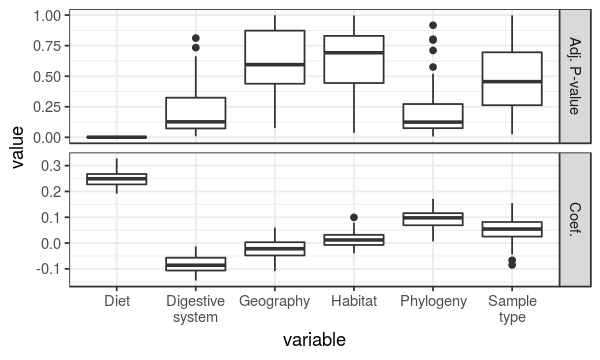

In [144]:
# formatting output
mrm_res_s = mrm_res %>% 
    filter(variable != 'Int') %>%
    gather(category, value, -variable, -R2, -pval, -F, -rep) %>%
    mutate(category = ifelse(category == 'coef', 'Coef.', 'Adj. P-value'))

mrm_res_s = mrm_res_s %>%
    inner_join(rename_df, c('variable'='old_name')) %>%
    dplyr::select(-variable) %>%
    rename('variable' = new_name)              

p = ggplot(mrm_res_s, aes(variable, value)) +
    geom_boxplot() +
    facet_grid(category ~ ., scales='free_y') +
    theme_bw()

options(repr.plot.width=5, repr.plot.height=3)
plot(p)

In [145]:
# significance
mrm_res %>% 
    group_by(variable) %>%
    summarize(pval_sensitivity = 1 - sum(coef_pval < 0.05) / length(pval)) %>%
    ungroup() %>%
    mutate(sig_pval_sensitivity = pval_sensitivity < 0.05)

variable,pval_sensitivity,sig_pval_sensitivity
Int,1.00,FALSE
m$diet,0.00,TRUE
m$digest,0.84,FALSE
m$geo,1.00,FALSE
m$habitat,0.99,FALSE
m$host_phy,0.83,FALSE
m$samp,0.97,FALSE


#### Model 2

In [146]:
# MRM on each permutation (in parallel)
doParallel::registerDoParallel(threads)
x = as.list(1:length(m_perm))
f = 'm$beta ~ m$host_phy + m$diet + m$habitat + m$geo + m$samp'
mrm_res = plyr::llply(x, mrm_each, L=m_perm, f=f, nperm=nperm, .parallel=TRUE)
mrm_res = do.call(rbind, mrm_res)
mrm_res %>% dfhead

[1] 600   7


,coef,coef_pval,variable,R2,pval,F,rep
Int,792.87734814,0.995,Int,0.06010524,0.007,29.92809,1
m$host_phy,0.09710063,0.119,m$host_phy,0.06010524,0.007,29.92809,1
m$diet,0.22759111,0.001,m$diet,0.06010524,0.007,29.92809,1


In [147]:
# summary of overall model
mrm_res %>%
    distinct(R2, pval, rep) %>%
    summary

       R2               pval              rep        
 Min.   :0.03795   Min.   :0.00100   Min.   :  1.00  
 1st Qu.:0.05344   1st Qu.:0.00100   1st Qu.: 25.75  
 Median :0.06257   Median :0.00400   Median : 50.50  
 Mean   :0.06379   Mean   :0.00757   Mean   : 50.50  
 3rd Qu.:0.07110   3rd Qu.:0.00900   3rd Qu.: 75.25  
 Max.   :0.11409   Max.   :0.04700   Max.   :100.00  

Warning message:
“Column `variable`/`old_name` joining character vector and factor, coercing into character vector”

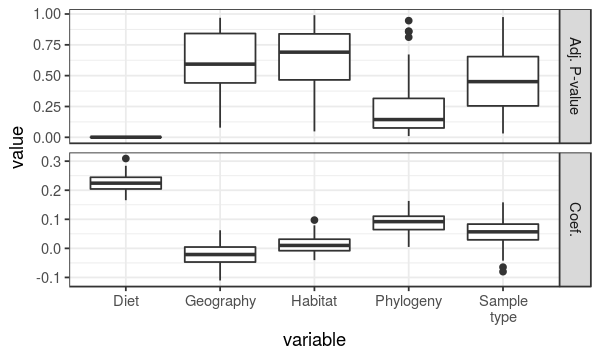

In [148]:
# formatting output
mrm_res_s = mrm_res %>% 
    filter(variable != 'Int') %>%
    gather(category, value, -variable, -R2, -pval, -F, -rep) %>%
    mutate(category = ifelse(category == 'coef', 'Coef.', 'Adj. P-value'))

mrm_res_s = mrm_res_s %>%
    inner_join(rename_df, c('variable'='old_name')) %>%
    dplyr::select(-variable) %>%
    rename('variable' = new_name)           

p = ggplot(mrm_res_s, aes(variable, value)) +
    geom_boxplot() +
    facet_grid(category ~ ., scales='free_y') +
    theme_bw()

options(repr.plot.width=5, repr.plot.height=3)
plot(p)

In [149]:
# significance
mrm_res %>% 
    group_by(variable) %>%
    summarize(pval_sensitivity = 1 - sum(coef_pval < 0.05) / length(pval)) %>%
    ungroup() %>%
    mutate(sig_pval_sensitivity = pval_sensitivity < 0.05)

variable,pval_sensitivity,sig_pval_sensitivity
Int,1.00,FALSE
m$diet,0.00,TRUE
m$geo,1.00,FALSE
m$habitat,0.99,FALSE
m$host_phy,0.89,FALSE
m$samp,0.96,FALSE


# sessionInfo


In [150]:
sessionInfo()

R version 3.4.1 (2017-06-30)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.1 LTS

Matrix products: default
BLAS: /ebio/abt3_projects/software/miniconda3_gt4.4/envs/py3_physeq_eco/lib/R/lib/libRblas.so
LAPACK: /ebio/abt3_projects/software/miniconda3_gt4.4/envs/py3_physeq_eco/lib/R/lib/libRlapack.so

locale:
[1] en_US.UTF-8

attached base packages:
[1] parallel  stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] bindrcpp_0.2.2    doParallel_1.0.11 iterators_1.0.10  foreach_1.4.4    
 [5] phyloseq_1.22.3   ecodist_2.0.1     ape_5.1           stringr_1.3.1    
 [9] ggplot2_3.0.0     tidyr_0.8.1       dplyr_0.7.6      

loaded via a namespace (and not attached):
 [1] Rcpp_0.12.17        lattice_0.20-34     Biostrings_2.46.0  
 [4] assertthat_0.2.0    digest_0.6.15       IRdisplay_0.4.4    
 [7] R6_2.2.2            plyr_1.8.4          repr_0.15.0        
[10] stats4_3.4.1        evaluate_0.10.1     pillar_1.2.2       